In [122]:
# imports
import os
import cv2
import numpy as np
import pandas as pd
import keras
from scipy import interp
from IPython.display import Image
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image as pilimg
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import types
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
np.random.seed(100)

In [3]:
print(os.listdir('input'))

['sample_submission.csv', 'test', 'train', 'train.csv']


In [4]:
data_dir = "input"
train_dir = data_dir + "/train/"
test_dir = data_dir + "/test/"
train_f_url = data_dir + "/train.csv"
test_f_url = data_dir + "/sample_submission.csv"
train_df = pd.read_csv(train_f_url)
test_df = pd.read_csv(test_f_url)

In [5]:
t_img_size = 200
Image(data=train_dir+train_df.iloc[0, 0], width=t_img_size, height=t_img_size)
print("Classification: 1 if has cactus 0 if no cactus : Value: {0}".format(train_df.iloc[0, 1]))

Classification: 1 if has cactus 0 if no cactus : Value: 1


In [6]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

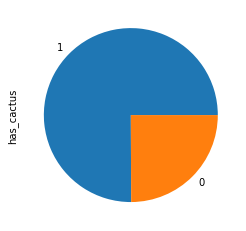

In [8]:
train_df['has_cactus'].value_counts().plot(kind='pie')

In [9]:
print("Test rows {0} and columns {1}".format(test_df.shape[0], test_df.shape[1]))

Test rows 4000 and columns 2


In [10]:
print("Train rows {0} and columns {1}".format(train_df.shape[0], train_df.shape[1]))

Train rows 17500 and columns 2


In [11]:
cacti = train_df[train_df.has_cactus==1].sample(n=3, random_state=42)
not_cacti = train_df[train_df.has_cactus==0].sample(n=3, random_state=50)

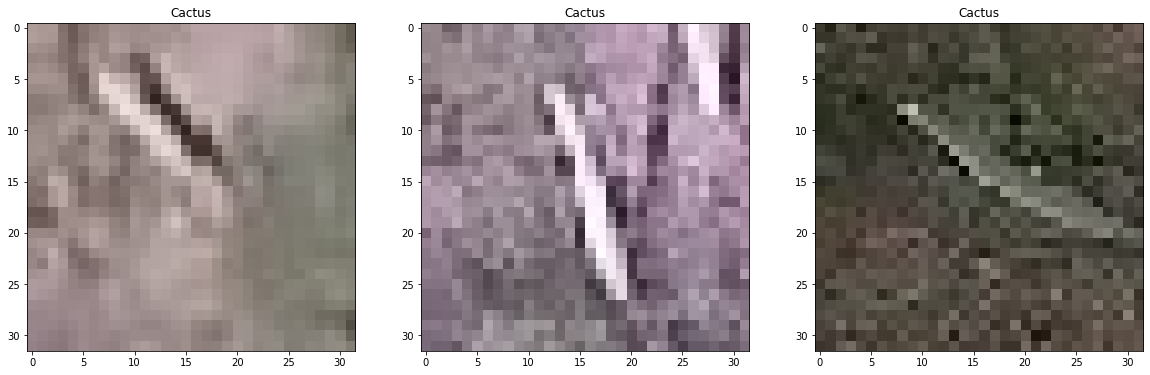

In [12]:
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = pilimg.open(train_dir + cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Cactus')
    ax.imshow(arr)
plt.show()

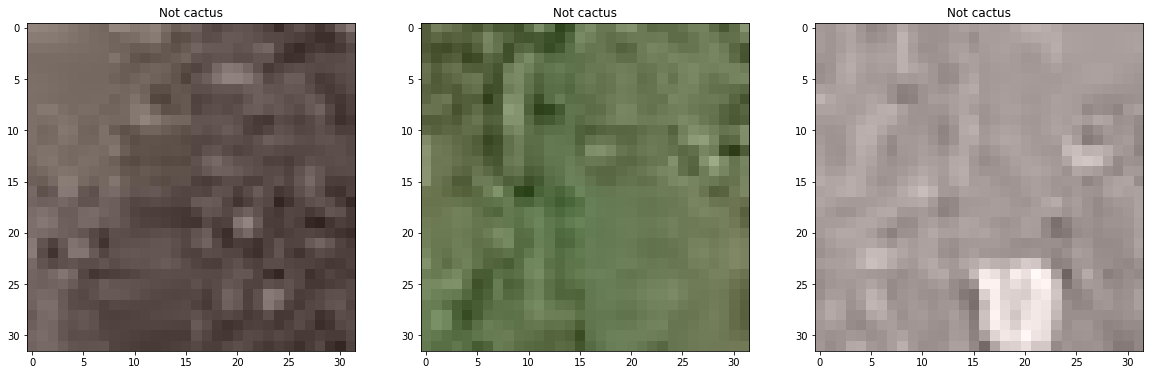

In [13]:
fig = plt.figure(1, figsize=(20, 20))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    pil_im = pilimg.open(train_dir + not_cacti.iloc[i, 0])
    im_arry = np.asarray(pil_im)
    arr = im_arry
    plt.title('Not cactus')
    ax.imshow(arr, cmap='viridis')
plt.show()

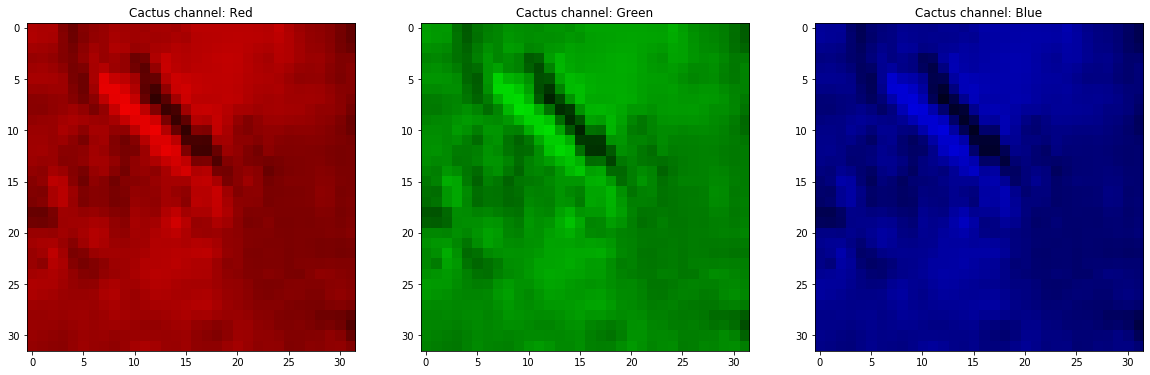

In [15]:
cactus_img = np.array(pilimg.open(train_dir + cacti.iloc[0, 0]))
fig = plt.figure(1, figsize=(20, 20))
channels = ['Red', 'Green', 'Blue']
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    temp = np.zeros(cactus_img.shape, dtype='uint8')
    temp[:,:,i] = cactus_img[:,:,i]
    ax.imshow(temp)
    plt.title("Cactus channel: " + channels[i])
plt.show()

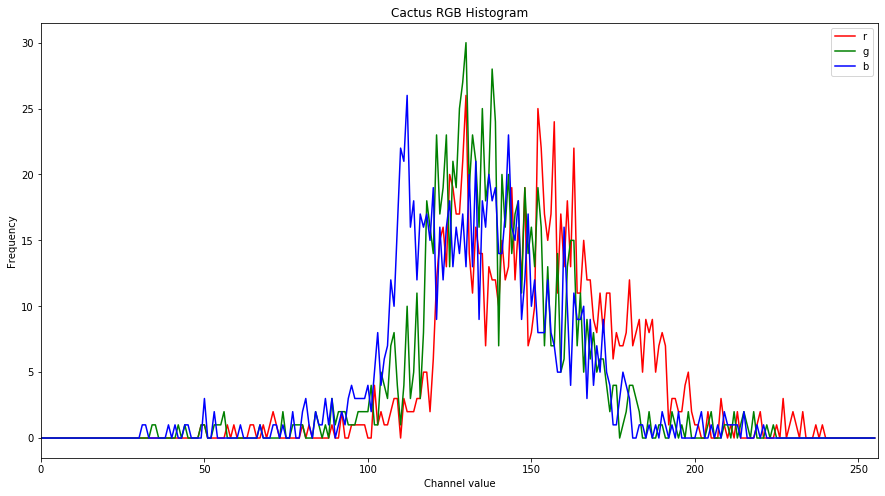

In [16]:
colors = [('Red', 'r'), ('Green', 'g'), ('Blue', 'b')]
fig = plt.figure(figsize=(15, 8))
for i in range(3):
    hist = cv2.calcHist([cactus_img], [i], None, [256], [0, 256])
    plt.plot(hist, color=colors[i][1], label=colors[i][1])
    plt.xlim([0, 256])
    plt.title("Cactus RGB Histogram")
    plt.xlabel("Channel value")
    plt.ylabel("Frequency")
    plt.legend()
plt.show()


In [17]:
train_df.has_cactus = train_df.has_cactus.astype(str)


In [18]:
def benchmark_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [19]:
model = benchmark_model()
model.summary()

W0716 23:16:48.921830 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 23:16:48.963808 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 23:16:48.965807 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 23:16:48.980796 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

In [20]:
plot_model(model, to_file='samplemodel.png', show_shapes=True, show_layer_names=True)

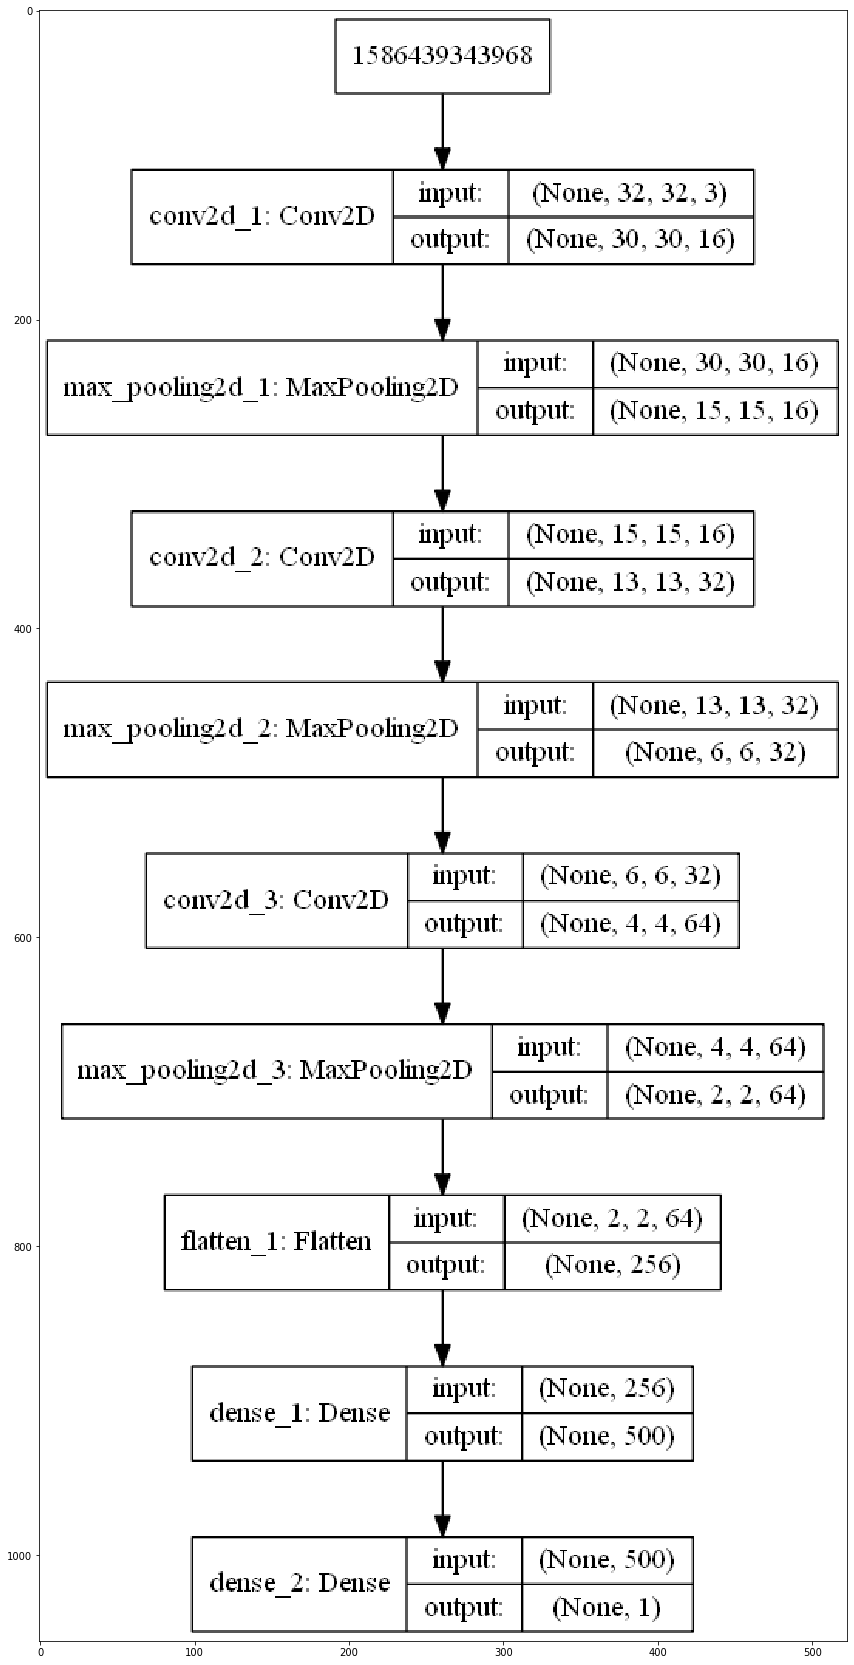

In [22]:
fig = plt.figure(figsize=(30, 30))
plt.imshow(pilimg.open('samplemodel.png'))
plt.show()

In [23]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy vs epochs')
    plt.ylabel('accuracy')
    plt.xlabel('no. of epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss vs epochs')
    plt.ylabel('loss')
    plt.xlabel('no. of epochs')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [24]:
def get_train_val_rows(train_df):
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_rows = train_df[:ind].shape[0] // 100
    val_rows = train_df[ind:].shape[0] // 50
    return train_rows, val_rows


In [25]:
def get_train_valid_generators_with_scale(train_df, target_size=32, train_batch_size=100, val_batch_size=50):
    train_df = shuffle(train_df)
    gen = ImageDataGenerator(rescale=1./255)
    len_train = len(train_df.index)
    ind = int(0.70*len_train)
    train_gen = gen.flow_from_dataframe(dataframe=train_df[:ind],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=train_batch_size,
                                                target_size=(target_size,target_size))


    val_gen = gen.flow_from_dataframe(dataframe=train_df[ind:],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=val_batch_size,
                                                    target_size=(target_size,target_size))
    return train_gen, val_gen, ind


In [26]:
train_rows, val_rows = get_train_val_rows(train_df)

In [27]:
train_gen, val_gen, ind = get_train_valid_generators_with_scale(train_df)

Found 12250 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames belonging to 2 classes.


In [28]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_gen.classes), train_gen.classes)

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model.fit_generator(train_gen, epochs=10, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

W0716 23:17:15.269637 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0716 23:17:15.299619 16928 deprecation_wrapper.py:119] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0716 23:17:15.305616 16928 deprecation.py:323] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0716 23:17:15.474517 16928 deprecation_wrapper.p

Epoch 1/10
122/122 [==============================] - 9s 75ms/step - loss: 0.2562 - acc: 0.8865 - val_loss: 0.1435 - val_acc: 0.9469
Epoch 2/10
122/122 [==============================] - 9s 71ms/step - loss: 0.1354 - acc: 0.9489 - val_loss: 0.1881 - val_acc: 0.9303
Epoch 3/10
122/122 [==============================] - 9s 71ms/step - loss: 0.1141 - acc: 0.9564 - val_loss: 0.0999 - val_acc: 0.9655
Epoch 4/10
122/122 [==============================] - 9s 71ms/step - loss: 0.0942 - acc: 0.9657 - val_loss: 0.0767 - val_acc: 0.9718
Epoch 5/10
122/122 [==============================] - 9s 70ms/step - loss: 0.0782 - acc: 0.9717 - val_loss: 0.0673 - val_acc: 0.9768
Epoch 6/10
122/122 [==============================] - 9s 70ms/step - loss: 0.0831 - acc: 0.9702 - val_loss: 0.0783 - val_acc: 0.9726
Epoch 7/10
122/122 [==============================] - 9s 70ms/step - loss: 0.0777 - acc: 0.9716 - val_loss: 0.0718 - val_acc: 0.9743
Epoch 8/10
122/122 [==============================] - 9s 70ms/step - 

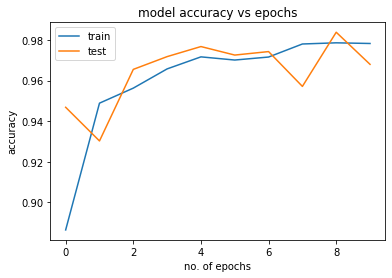

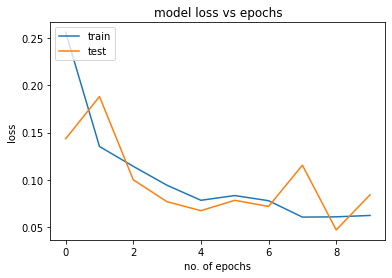

In [30]:
plot_history(history1)

In [31]:
# Benchmark model has training acc greater than test accuracy -> could mean overfitting, solution: dropout
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

W0716 23:18:59.880308 16928 deprecation.py:506] From c:\users\sraddhanjali acharya\pycharmprojects\udacity\aerialcactusidentify\ve\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model.fit_generator(train_gen, epochs=10, class_weight=class_weights, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows)

Epoch 1/10
122/122 [==============================] - 11s 88ms/step - loss: 0.3439 - acc: 0.8451 - val_loss: 0.2362 - val_acc: 0.9067
Epoch 2/10
122/122 [==============================] - 11s 91ms/step - loss: 0.1595 - acc: 0.9371 - val_loss: 0.1449 - val_acc: 0.9491
Epoch 3/10
122/122 [==============================] - 11s 87ms/step - loss: 0.1376 - acc: 0.9466 - val_loss: 0.1236 - val_acc: 0.9581
Epoch 4/10
122/122 [==============================] - 11s 87ms/step - loss: 0.1206 - acc: 0.9546 - val_loss: 0.1153 - val_acc: 0.9615
Epoch 5/10
122/122 [==============================] - 11s 88ms/step - loss: 0.0977 - acc: 0.9632 - val_loss: 0.0933 - val_acc: 0.9667
Epoch 6/10
122/122 [==============================] - 13s 105ms/step - loss: 0.1011 - acc: 0.9618 - val_loss: 0.1235 - val_acc: 0.9545
Epoch 7/10
122/122 [==============================] - 13s 108ms/step - loss: 0.0836 - acc: 0.9700 - val_loss: 0.0993 - val_acc: 0.9613
Epoch 8/10
122/122 [==============================] - 15s 12

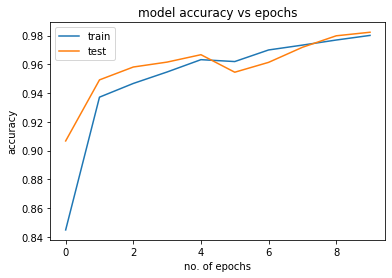

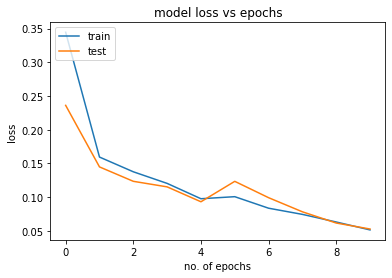

In [33]:
plot_history(history2)

In [43]:
def build_classifier(optimizer):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [176]:
n_splits = 3
val_preds = {i: [] for i in range(0, n_splits)}
val_labels = {}
train_preds = {i: [] for i in range(0, n_splits)}
train_labels = {}
history_log = {}
aug_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rescale=1./255)
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10).split(train_df['id'], train_df['has_cactus']))
for i, (train_idx, valid_idx) in enumerate(splits):
    atrain_gen = aug_gen.flow_from_dataframe(dataframe=train_df.iloc[train_idx],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=100,
                                            target_size=(32, 32), shuffle=False, drop_duplicates=True, seed=2019, pickle_safe=True, workers=1)
    val_gen = aug_gen.flow_from_dataframe(dataframe=train_df.iloc[valid_idx],directory=train_dir,x_col='id',
                                                    y_col='has_cactus',class_mode='binary',batch_size=50,
                                                    target_size=(32, 32), shuffle=False, drop_duplicates=True, seed=2019, pickle_safe=True, workers=1)
    
    train_rows = np.ceil(len(atrain_gen.classes)/100)
    val_rows = np.ceil(len(val_gen.classes)/50)
    train_labels[i] = atrain_gen.classes
    val_labels[i] = val_gen.classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(atrain_gen.classes), atrain_gen.classes)
    callbacks = ModelCheckpoint(filepath='model3_{0}.best.hd5'.format(i), monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model = build_classifier('adam')
    history_log[i] = model.fit_generator(atrain_gen, epochs=20,steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights, callbacks=[callbacks])
    model.load_weights('model3_{0}.best.hd5'.format(i))
    atrain_gen.reset()
    val_gen.reset()
    train_preds[i].append(model.predict_generator(atrain_gen, steps=train_rows, max_queue_size=1))
    val_preds[i].append(model.predict_generator(val_gen, steps=val_rows, max_queue_size=1))

SyntaxError: invalid syntax (<ipython-input-176-92258bf5bf1a>, line 24)

In [158]:
# taken from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

def plot_roc_curve(labels, preds):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(0, n_splits):
        pred_flat = np.array(preds[i]).flatten()
        fpr, tpr, thresholds = metrics.roc_curve(labels[i], pred_flat)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    

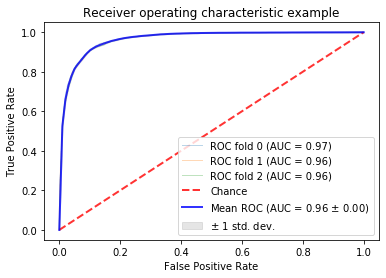

In [171]:
plot_roc_curve(train_labels, train_preds)


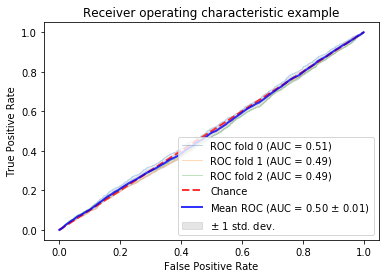

In [167]:
plot_roc_curve(val_labels, val_preds)

In [119]:
train_roc_auc_scores

{0: [(array([0.        , 0.01031282, 0.01237539, ..., 0.99862496, 0.99862496,
          1.        ]),
   array([0.        , 0.01541624, 0.0162156 , ..., 0.99862967, 1.        ,
          1.        ]),
   array([2.0000000e+00, 1.0000000e+00, 9.9999994e-01, ..., 2.1345913e-03,
          1.8297136e-03, 1.5866458e-03], dtype=float32))],
 1: [(array([0.        , 0.01650052, 0.02200069, ..., 0.99965624, 1.        ,
          1.        ]),
   array([0.        , 0.01336074, 0.01632979, ..., 0.99931483, 0.99931483,
          1.        ]),
   array([2.0000000e+00, 1.0000000e+00, 9.9999994e-01, ..., 9.1812015e-04,
          9.1367960e-04, 5.9425831e-04], dtype=float32))],
 2: [(array([0.        , 0.00309278, 0.00378007, ..., 0.99965636, 1.        ,
          1.        ]),
   array([0.        , 0.0036538 , 0.00479562, ..., 0.99977164, 0.99977164,
          1.        ]),
   array([2.0000000e+00, 1.0000000e+00, 9.9999994e-01, ..., 3.9136410e-04,
          3.9032102e-04, 3.6102533e-04], dtype=float32

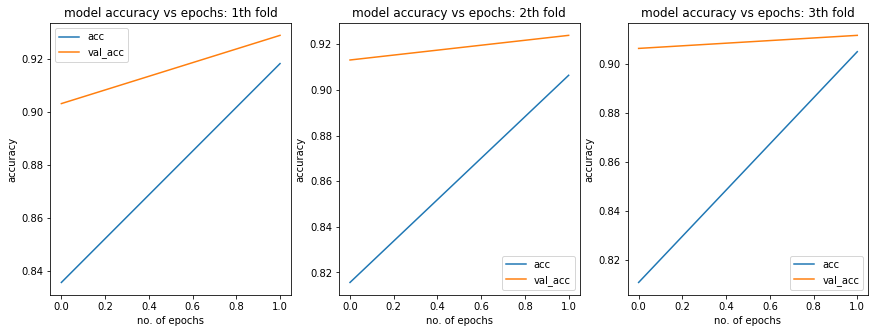

In [169]:
fig = plt.figure(1, figsize=(25, 5))
for i in range(n_splits):
    ax = fig.add_subplot(1, 5, i+1)
    plt.plot(history_log[i].history['acc'], label='acc')
    plt.plot(history_log[i].history['val_acc'], label='val_acc')
    plt.title('model accuracy vs epochs: {0}th fold'.format(i+1))
    plt.ylabel('accuracy')
    plt.xlabel('no. of epochs')
    plt.legend(loc='best')
plt.show()

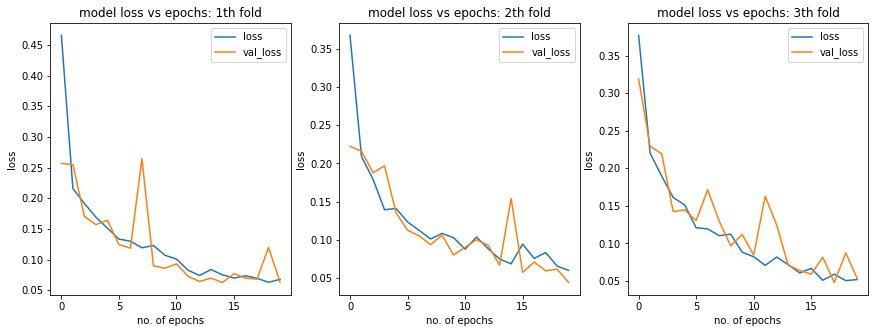

In [133]:
fig = plt.figure(1, figsize=(25, 5))
for i in range(n_splits):
    ax = fig.add_subplot(1, 5, i+1)
    plt.plot(history_log[i].history['loss'], label='loss')
    plt.plot(history_log[i].history['val_loss'], label='val_loss')
    plt.title('model loss vs epochs: {0}th fold'.format(i+1))
    plt.ylabel('loss')
    plt.xlabel('no. of epochs')
    plt.legend(loc='best')
plt.show()

In [ ]:
metrics = ['acc', 'val_acc', 'loss', 'val_loss']
inner_dict = {m: [] for m in metrics}
results = {i: inner_dict for i in range(1, n_splits+1)}
for i in range(1, n_splits+1):
    results[i]['acc'].append(np.mean(history_log[i-1].history['acc']))
    results[i]['val_acc'].append(np.mean(history_log[i-1].history['val_acc']))
    results[i]['loss'].append(np.mean(history_log[i-1].history['loss']))
    results[i]['val_loss'].append(np.mean(history_log[i-1].history['val_loss']))

fig = plt.figure(1, figsize=(10, 5))  
folds = [i for i in range(1, n_splits+1)]
for i in range(1, n_splits+1):
    plt.plot(folds, results[i]['acc'], 'r--', label='acc' if i == 5 else '')
    plt.plot(folds, results[i]['val_acc'], 'b--', label='val_acc' if i == 5 else '')
    plt.plot(folds, results[i]['loss'], 'g--', label='loss' if i == 5 else '')
    plt.plot(folds, results[i]['val_loss'], 'm--', label='val_loss' if i == 5 else '')
    plt.title('metrics per fold')
    plt.ylabel('metrics')
    plt.xlabel('no. of folds')
plt.legend(loc='best')
plt.show()

In [ ]:
history3 = model.fit_generator(atrain_gen, epochs=10, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

In [ ]:
plot_history(history3)

In [ ]:
x_test = []
ids = []
for f in os.listdir(test_dir):
    ids.append(f)
    path = os.path.join(test_dir, f)
    pil_arr = np.asarray(img.open(path))
    x_test.append(pil_arr)
x_test = np.array(x_test)
print(x_test.shape)
x_test = x_test.astype('float32')/255

In [ ]:
predictions = model.predict_proba(x_test)

In [ ]:
test_df = pd.DataFrame({'id': ids, 'has_cactus': predictions.flatten()})

In [ ]:
test_df.to_csv("samplesubmission.csv", index=False)

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg16)
vgg_model.add(Flatten())
vgg_model.add(Dense(500, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(300, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(100, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.summary()

In [ ]:
vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history4 = vgg_model.fit_generator(train_gen, epochs=50, shuffle=True, steps_per_epoch=train_rows, validation_data=val_gen, validation_steps=val_rows, class_weight=class_weights)

In [ ]:
plot_history(history4)

In [ ]:
vgg_predictions = model.predict_proba(x_test)

In [ ]:
vgg_df = pd.DataFrame({'id': ids, 'has_cactus': vgg_predictions.flatten()})

In [ ]:
vgg_df.to_csv("vggsubmission.csv", index=False)